In [1]:
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import json


In [2]:

with open('theoretical_experimental_structures.json', 'r') as f:
    data = json.load(f)

In [16]:
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

path_to_cifs = "/Users/pamco116/OneDrive - Uppsala universitet/Documents/selected_cifs/"

# Add computed volumes for both MP and ICSD structures
for icsd_id in data:
    # Process MP structure
    try:
        mp_structure = Structure.from_dict(data[icsd_id]['MP']['structure'])
        sga_mp = SpacegroupAnalyzer(mp_structure)
        
        mp_primitive = sga_mp.get_primitive_standard_structure()
        mp_conventional = sga_mp.get_conventional_standard_structure()
        
        data[icsd_id]['MP']['volume_primitive_pymatgen'] = mp_primitive.volume
        data[icsd_id]['MP']['volume_conventional_pymatgen'] = mp_conventional.volume
    except (ValueError, KeyError):
        data[icsd_id]['MP']['volume_primitive_pymatgen'] = None
        data[icsd_id]['MP']['volume_conventional_pymatgen'] = None
    
    # Process ICSD structure
    try:
        icsd_structure = Structure.from_file(path_to_cifs + f'icsd_{icsd_id}.cif')
        sga_icsd = SpacegroupAnalyzer(icsd_structure)
        
        icsd_primitive = sga_icsd.get_primitive_standard_structure()
        icsd_conventional = sga_icsd.get_conventional_standard_structure()
        
        data[icsd_id]['ICSD']['volume_primitive_pymatgen'] = icsd_primitive.volume
        data[icsd_id]['ICSD']['volume_conventional_pymatgen'] = icsd_conventional.volume
    except (ValueError, FileNotFoundError):
        data[icsd_id]['ICSD']['volume_primitive_pymatgen'] = None
        data[icsd_id]['ICSD']['volume_conventional_pymatgen'] = None

/Users/pamco116/miniconda3/envs/repo_env/lib/python3.11/site-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/Users/pamco116/miniconda3/envs/repo_env/lib/python3.11/site-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: Structure has implicit hydrogens defined, parsed structure unlikely to be suitable for use in calculations unless hydrogens added.
  struct = parser.parse_structures(primitive=primitive)[0]
/Users/pamco116/miniconda3/envs/repo_env/lib/python3.11/site-packages/pymatgen/core/structure.py:3109: UserWarning: Issues encountered while parsing CIF: 1 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/Users/pamco116/miniconda3/envs/repo_env/lib/python3.1

In [21]:
volumes = {}

for item in data:
    volumes[item] = {'MP': {}, 'ICSD': {}}
    
    volumes[item]['MP'] = {
        'volume_primitive_pymatgen': data[item]['MP'].get('volume_primitive_pymatgen', None),
        'volume_conventional_pymatgen': data[item]['MP'].get('volume_conventional_pymatgen', None)
    }
    
    volumes[item]['ICSD'] = {
        'volume_primitive_pymatgen': data[item]['ICSD'].get('volume_primitive_pymatgen', None),
        'volume_conventional_pymatgen': data[item]['ICSD'].get('volume_conventional_pymatgen', None),
        'volume_reported': data[item]['ICSD'].get('volume_reported', None)

    }

In [76]:
import pandas as pd

# Create lists to store data
records = []

for icsd_id, volumes in data.items():
    # Primitive volumes
    mp_prim = volumes['MP']['volume_primitive_pymatgen']
    icsd_prim = volumes['ICSD']['volume_primitive_pymatgen']
    
    # Use reported volume as fallback for ICSD
    if icsd_prim is None:
        icsd_prim = volumes['ICSD'].get('volume_reported')
    
    # Conventional volumes
    mp_conv = volumes['MP']['volume_conventional_pymatgen']
    icsd_conv = volumes['ICSD']['volume_conventional_pymatgen']

    # Check for None values
    has_none = any(v is None for v in [mp_prim, icsd_prim, mp_conv, icsd_conv])
    
    # Use reported volume as fallback for ICSD
    if icsd_conv is None:
        icsd_conv = volumes['ICSD'].get('volume_reported')

    
    records.append({
        'icsd_id': icsd_id,
        'mp_primitive': mp_prim,
        'icsd_primitive': icsd_prim,
        'mp_conventional': mp_conv,
        'icsd_conventional': icsd_conv,
        'error_primitive': (icsd_prim - mp_prim),
        'sqerror_primitive': (icsd_prim - mp_prim)**2,        
        'error_conventional': (icsd_conv - mp_conv),
        'error_conventional_perc': ((icsd_conv - mp_conv)/icsd_conv)*100,
        'has_missing_volume': has_none
    })

df = pd.DataFrame(records)

In [55]:
print (f"Materials with corrupted CIF file: {len(df[df['has_missing_volume'] == True])}")

print (f"Materials with complete CIF file: {len(df[df['has_missing_volume'] == False])}")

Materials with corrupted CIF file: 2482
Materials with complete CIF file: 11046


In [132]:
df[df['has_missing_volume'] == True]

,icsd_id,mp_primitive,icsd_primitive,mp_conventional,icsd_conventional,error_primitive,sqerror_primitive,error_conventional,error_conventional_perc,has_missing_volume
2,100712,635.545238,587.02,635.545238,587.02,-48.525238,2.354699e+03,-48.525238,-8.266369,True
9,048006,614.874058,602.81,614.874058,602.81,-12.064058,1.455415e+02,-12.064058,-2.001304,True
10,075551,1201.172662,1153.94,1201.172662,1153.94,-47.232662,2.230924e+03,-47.232662,-4.093164,True
11,073920,183.826533,380.48,367.653066,380.48,196.653467,3.867259e+04,12.826934,3.371250,True
12,001955,935.926645,1544.31,1871.853291,1544.31,608.383355,3.701303e+05,-327.543291,-21.209685,True
...,...,...,...,...,...,...,...,...,...,...
13514,016034,832.185470,761.10,832.185470,761.10,-71.085470,5.053144e+03,-71.085470,-9.339833,True
13515,041159,342.742684,2137.72,1370.970734,2137.72,1794.977316,3.221944e+06,766.749266,35.867619,True
13516,155000,1743.325238,1698.37,1743.325238,1698.37,-44.955238,2.020973e+03,-44.955238,-2.646964,True
13524,002620,572.622321,1584.95,1145.244642,1584.95,1012.327679,1.024807e+06,439.705358,27.742538,True


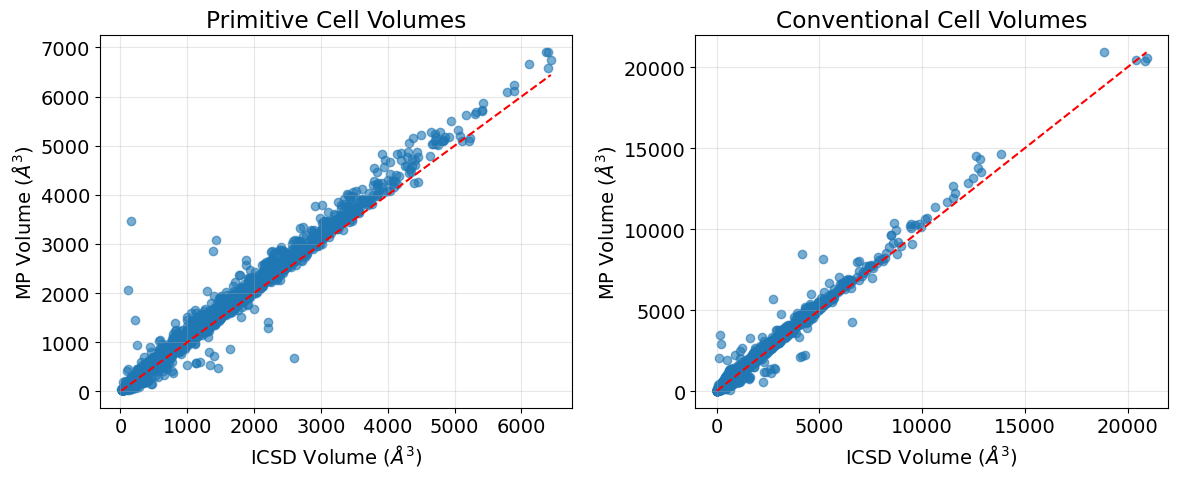

Primitive cells: 11046 structures
Conventional cells: 11046 structures


In [129]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

# Filter out rows with missing values
df_complete = df[df['has_missing_volume'] == False]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Primitive cells
ax1.scatter(df_complete['icsd_primitive'], df_complete['mp_primitive'], alpha=0.6)
ax1.plot([df_complete['icsd_primitive'].min(), df_complete['icsd_primitive'].max()], 
         [df_complete['icsd_primitive'].min(), df_complete['icsd_primitive'].max()], 'r--')
ax1.set_xlabel('ICSD Volume ($\AA^3$)')
ax1.set_ylabel('MP Volume ($\AA^3$)')
ax1.set_title('Primitive Cell Volumes')
ax1.grid(alpha=0.3)

# Conventional cells
ax2.scatter(df_complete['icsd_conventional'], df_complete['mp_conventional'], alpha=0.6)
ax2.plot([df_complete['icsd_conventional'].min(), df_complete['icsd_conventional'].max()], 
         [df_complete['icsd_conventional'].min(), df_complete['icsd_conventional'].max()], 'r--')
ax2.set_xlabel('ICSD Volume ($\AA^3$)')
ax2.set_ylabel('MP Volume ($\AA^3$)')
ax2.set_title('Conventional Cell Volumes')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Primitive cells: {len(df_complete)} structures")
print(f"Conventional cells: {len(df_complete)} structures")

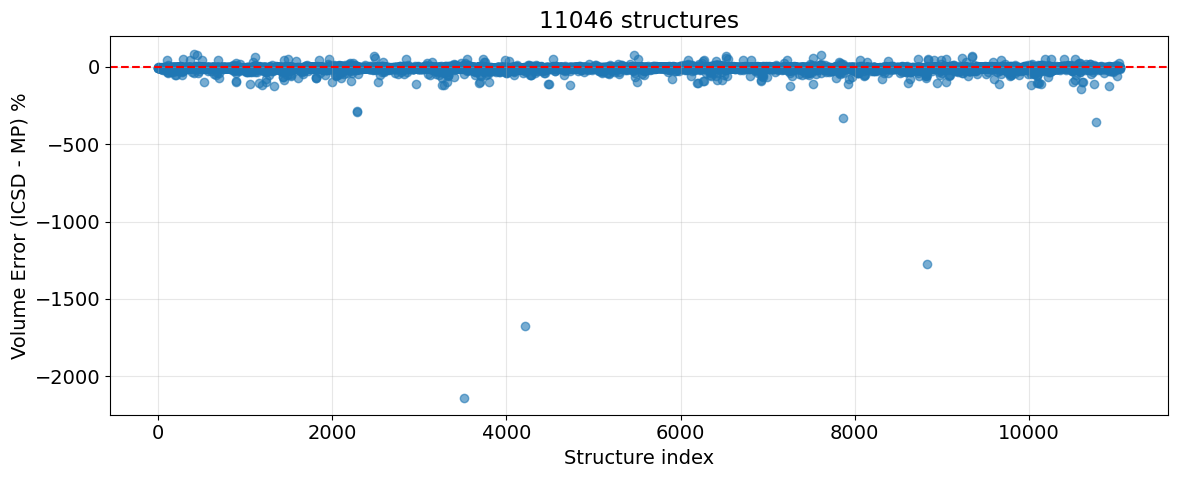

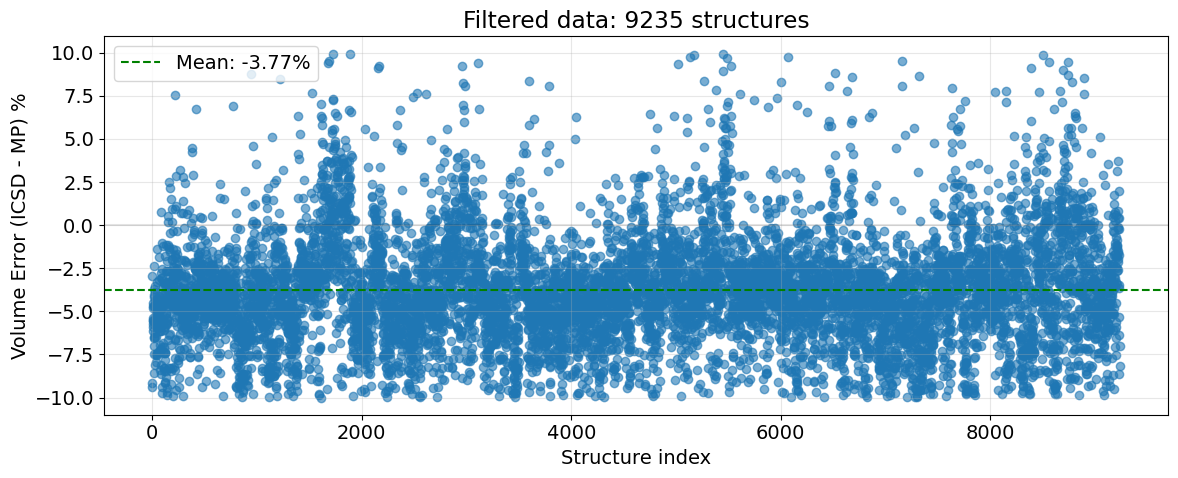

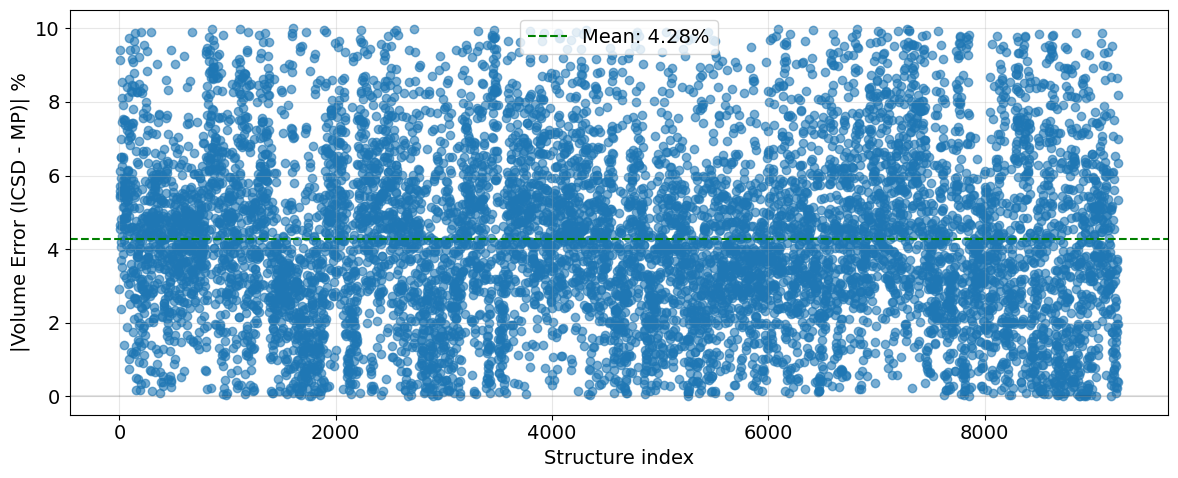

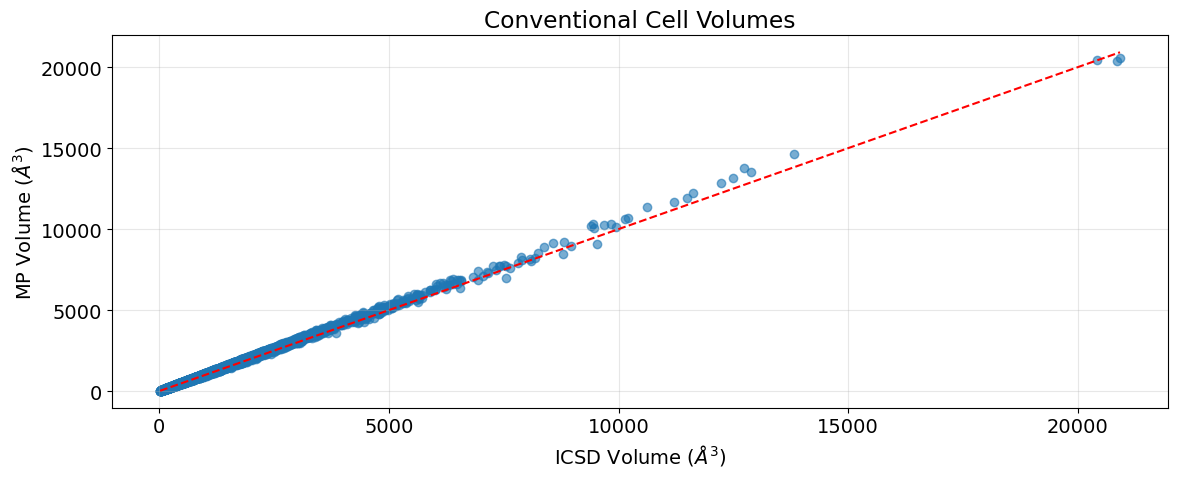

In [130]:
import numpy as np


# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

# Error scatter plot
ax1.scatter(range(len(df_complete['error_conventional_perc'])), df_complete['error_conventional_perc'], alpha=0.6)
ax1.axhline(0, color='r', linestyle='--')
#ax1.axhline(mean_error, color='g', linestyle='--', label=f'Mean: {mean_error:.2f} ± {sem:.2f}')
#ax1.fill_between(range(len(df['error_conventional_perc'])), mean_error - sem, mean_error + sem, 
#                  alpha=0.2, color='g', label='SEM')
ax1.set_xlabel('Structure index')
ax1.set_ylabel('Volume Error (ICSD - MP) %')
# ax1.set_ylim(-1000,1000)
ax1.set_title(f'{len(df_complete)} structures')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#Filter the data

df_filtered = df_complete[np.abs(df_complete['error_conventional_perc']) < 10]

mean_error = df_filtered['error_conventional_perc'].mean()
std_error = df_filtered['error_conventional_perc'].std()
sem = std_error / np.sqrt(len(df_filtered['error_conventional_perc']))

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

# Error scatter plot
ax1.scatter(range(len(df_filtered['error_conventional_perc'])), df_filtered['error_conventional_perc'], alpha=0.6)
ax1.axhline(0, color='k', linestyle='-', alpha=0.1)
ax1.axhline(mean_error, color='g', linestyle='--', label=f'Mean: {mean_error:.2f}%')
#ax1.fill_between(range(len(df['error_conventional_perc'])), mean_error - sem, mean_error + sem, 
#                  alpha=0.2, color='g', label='SEM')
ax1.set_xlabel('Structure index')
ax1.set_ylabel('Volume Error (ICSD - MP) %')
# ax1.set_ylim(-1000,1000)
ax1.legend()
ax1.set_title(f'Filtered data: {len(df_filtered)} structures')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()


abs_mean_error = np.abs(df_filtered['error_conventional_perc']).mean()
std_error = np.abs(df_filtered['error_conventional_perc']).std()
sem = std_error / np.sqrt(len(df_filtered['error_conventional_perc']))

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

# Error scatter plot
ax1.scatter(range(len(df_filtered['error_conventional_perc'])), np.abs(df_filtered['error_conventional_perc']), alpha=0.6)
ax1.axhline(0, color='k', linestyle='-', alpha=0.1)
ax1.axhline(abs_mean_error, color='g', linestyle='--', label=f'Mean: {abs_mean_error:.2f}%')
ax1.set_xlabel('Structure index')
ax1.set_ylabel('|Volume Error (ICSD - MP)| %')
# ax1.set_ylim(-5,20)
# ax1.set_xlim(0,12000)
ax1.legend()
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

ax1.scatter(df_filtered['icsd_conventional'], df_filtered['mp_conventional'], alpha=0.6)
ax1.plot([df_filtered['icsd_conventional'].min(), df_filtered['icsd_conventional'].max()], 
      [df_filtered['icsd_conventional'].min(), df_filtered['icsd_conventional'].max()], 'r--')
ax1.set_xlabel('ICSD Volume ($\AA^3$)')
ax1.set_ylabel('MP Volume ($\AA^3$)')
ax1.set_title('Conventional Cell Volumes')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

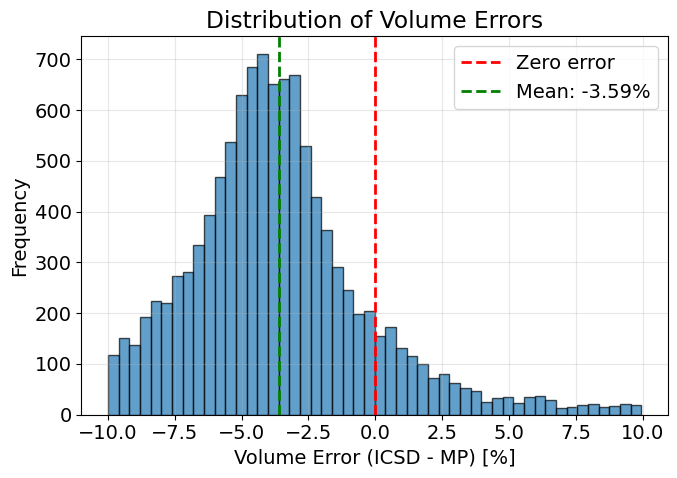

Mean error: -3.59 ± 0.03 %


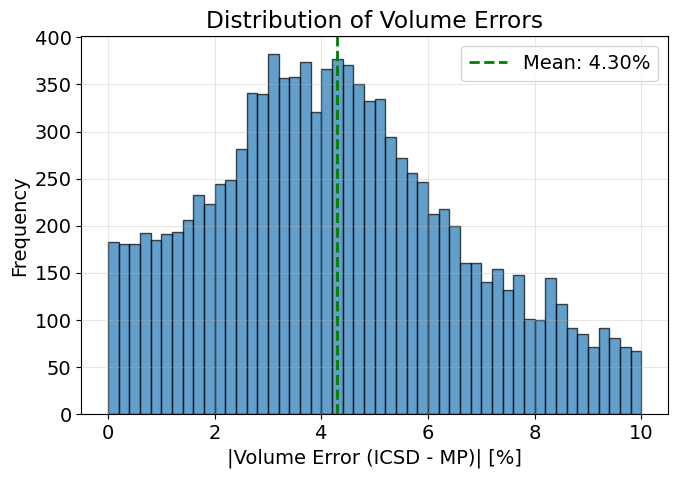

Mean error: 4.30 ± 0.02 %


In [114]:
# Sort errors
error = df_filtered['error_conventional_perc']

# Average error
average_error = np.mean(error)
std_error = np.std(error)
sem = std_error / np.sqrt(len(error))

# Histogram
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.hist(error, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
ax.axvline(average_error, color='g', linestyle='--', linewidth=2, 
           label=f'Mean: {average_error:.2f}%')
ax.set_xlabel('Volume Error (ICSD - MP) [%]')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Volume Errors')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean error: {average_error:.2f} ± {sem:.2f} %")

# Sort errors
error = np.abs(df_filtered['error_conventional_perc'])

# Average error
average_error = np.mean(error)
std_error = np.std(error)
sem = std_error / np.sqrt(len(error))

# Histogram
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.hist(error, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(average_error, color='g', linestyle='--', linewidth=2, 
           label=f'Mean: {average_error:.2f}%')
ax.set_xlabel('|Volume Error (ICSD - MP)| [%]')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Volume Errors')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean error: {average_error:.2f} ± {sem:.2f} %")

In [115]:
df_filtered.to_csv('volume_comparison.csv', index=False)